<a href="https://colab.research.google.com/github/dmahdipour/DmyShapesDataset/blob/main/DmyShapesDataset_PretrainedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import zipfile
from pathlib import Path
from tqdm.auto import tqdm
import os
from timeit import default_timer as timer
from typing import Tuple, Dict, List
import random
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary

In [2]:
try:
  from py import data_setup, engine
except:
  # Get the py scripts
  print("[INFO] Couldn't find py scripts... downloading them from GitHub.")
  !git clone https://github.com/dmahdipour/pytorch
  !mv pytorch/py_functions .
  !rm -rf pytorch
  from py_functions import data_setup, engine

[INFO] Couldn't find py scripts... downloading them from GitHub.
Cloning into 'pytorch'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 72 (delta 24), reused 21 (delta 3), pack-reused 0
Receiving objects: 100% (72/72), 18.12 MiB | 36.03 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [3]:
image_path = Path("dmy_shapes_dataset")

if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  with open("dmy_shapes_dataset.zip", "wb") as f:
    request = requests.get("https://github.com/dmahdipour/DmyShapesDataset/raw/main/Datasets/dmy_shapes_dataset.zip")
    print("Downloading data...")
    f.write(request.content)

  with zipfile.ZipFile("dmy_shapes_dataset.zip", "r") as zip_ref:
    print("Unzipping data...")
    zip_ref.extractall(image_path)

Did not find dmy_shapes_dataset directory, creating one...
Unzipping data...


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('dmy_shapes_dataset/train'), PosixPath('dmy_shapes_dataset/test'))

In [5]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [6]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
WIDTH=224
HEIGHT=224

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78854533f9d0>,
 ['Circle', 'Polygon', 'Rectangle', 'Square', 'Triangle'])

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 62.6MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
for param in model.features.parameters():
  param.requires_grad = False

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [12]:
summary(model,
        input_size=(32, 3, HEIGHT, WIDTH),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7824 | train_acc: 0.6970 | test_loss: 0.4679 | test_acc: 0.8091
Epoch: 2 | train_loss: 0.5177 | train_acc: 0.7877 | test_loss: 0.4077 | test_acc: 0.8341
Epoch: 3 | train_loss: 0.4619 | train_acc: 0.8105 | test_loss: 0.3828 | test_acc: 0.8448
Epoch: 4 | train_loss: 0.4270 | train_acc: 0.8210 | test_loss: 0.3773 | test_acc: 0.8288
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.8115 | test_loss: 0.3582 | test_acc: 0.8509
Epoch: 6 | train_loss: 0.4139 | train_acc: 0.8153 | test_loss: 0.3515 | test_acc: 0.8474
Epoch: 7 | train_loss: 0.4104 | train_acc: 0.8235 | test_loss: 0.3558 | test_acc: 0.8448
Epoch: 8 | train_loss: 0.3978 | train_acc: 0.8277 | test_loss: 0.3385 | test_acc: 0.8517
Epoch: 9 | train_loss: 0.3920 | train_acc: 0.8290 | test_loss: 0.3405 | test_acc: 0.8482
Epoch: 10 | train_loss: 0.3854 | train_acc: 0.8307 | test_loss: 0.3388 | test_acc: 0.8566
[INFO] Total training time: 182.805 seconds


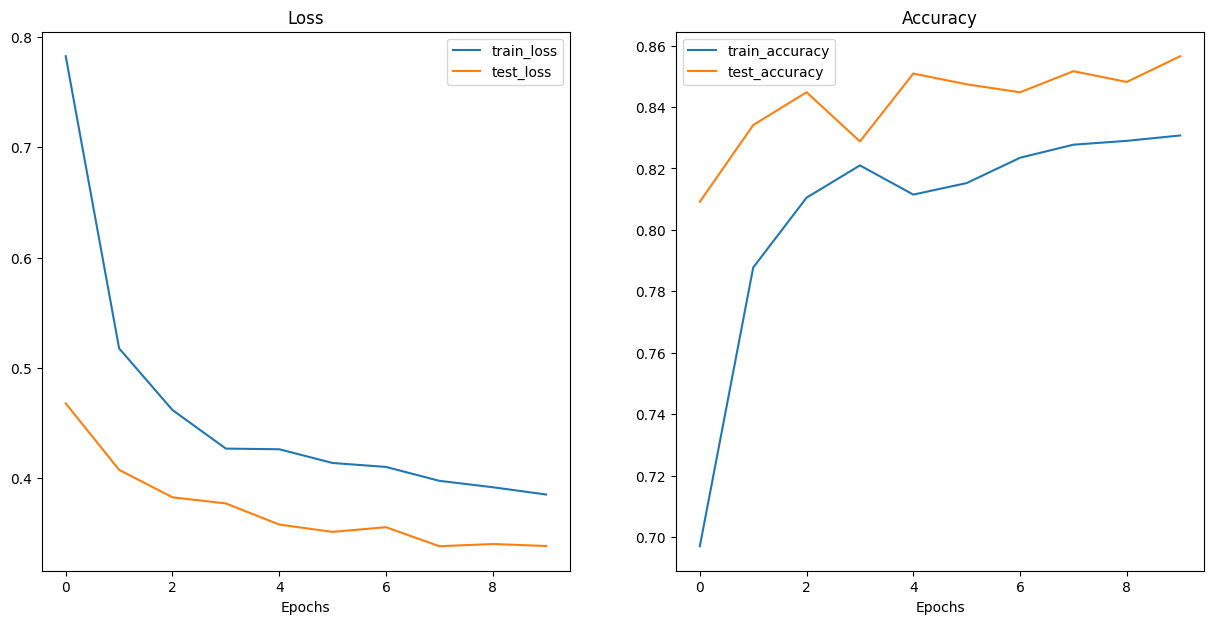

In [15]:
from py_functions.helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [16]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

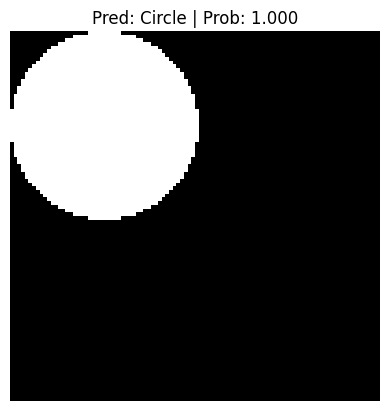

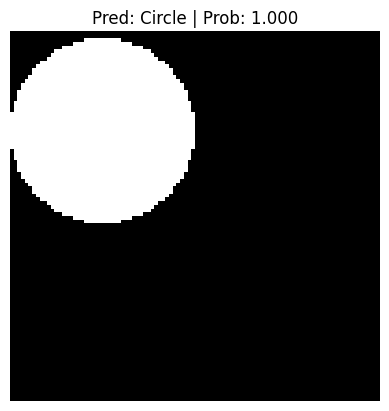

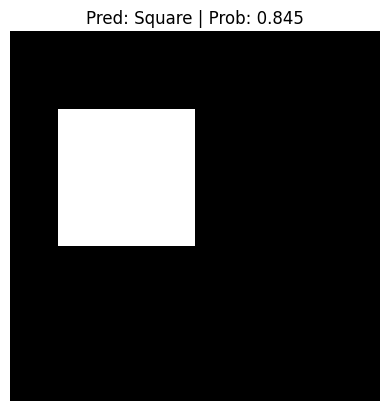

In [17]:
import random
random.seed(42)
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.png")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                      image_size=(224, 224))

In [22]:
custom_image_path = Path("dmy_shapes_dataset/test.jpg")

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/dmahdipour/DmyShapesDataset/main/Datasets/test.jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

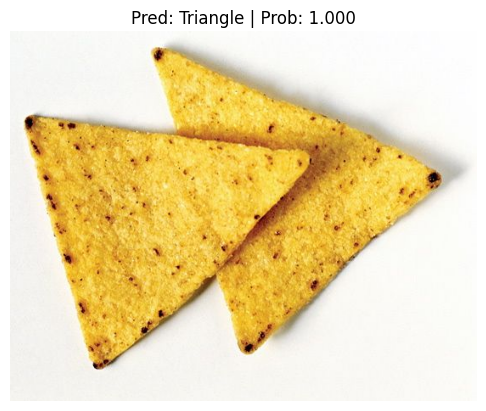

In [23]:
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)